In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from models import common, supervised_models, read_data

# 1. DATA

## 1.1. Common Data for Time Series and Regression

In [3]:
read_data.read_data_common?

Signature: read_data.read_data_common(path)
Docstring:
Read Earthquake file and return 2 dataframes.

:return: sismos  and all_months dataframes

sismos = ['id', 'date', 'latitude', 'longitude', 'depth', 'mag', 'place', 'time',
            'year', 'month', 'YM', 'magtype', 'distcity', 'city', 'mag_int' ]

all_months = list of all months from  January 1979 to June 2019
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [4]:
sismos, all_months = read_data.read_data_common('./data/')

Information related to earthquakes from 1979 until 2019

In [5]:
sismos.head(2)

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int
18521,usp0000z70,1979-03-07,-32.699,-71.942,29.0,4.9,"offshore Valparaiso, Chile",1979-03-07 22:57:09.600000+00:00,1979,3,1979-03-01,medium,0,Valparaiso,4
18520,usp0000zk2,1979-03-22,-31.796,-69.867,117.0,4.7,"San Juan, Argentina",1979-03-22 06:51:10.600000+00:00,1979,3,1979-03-01,medium,0,San Juan,4


In [6]:
sismos.describe()

,latitude,longitude,depth,mag,year,month,mag_int
count,18522.000000,18522.000000,18522.000000,18522.000000,18522.000000,18522.000000,18522.00000
mean,-33.245880,-71.081183,51.188379,3.505518,2000.989904,6.468146,3.03423
std,0.882855,0.836668,41.817346,0.653193,6.320555,3.403769,0.73547
min,-35.231000,-72.793000,0.000000,2.500000,1979.000000,1.000000,2.00000
25%,-33.951000,-71.783000,14.900000,3.000000,1997.000000,3.000000,3.00000
50%,-33.144000,-71.173000,35.000000,3.500000,2001.000000,6.000000,3.00000
75%,-32.524250,-70.352000,88.800000,3.900000,2005.000000,9.000000,3.00000
max,-31.639000,-68.504000,226.100000,8.000000,2019.000000,12.000000,8.00000


### Check null values

In [7]:
sismos.isnull().sum(axis = 0)

id           0
date         0
latitude     0
longitude    0
depth        0
mag          0
place        0
time         0
year         0
month        0
YM           0
magtype      0
distcity     0
city         0
mag_int      0
dtype: int64

In [8]:
sismos.isnull().values.any()

False

### Duplicates

There is no duplicates by id

In [9]:
sismos[sismos['id'].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int


In [10]:
sismos[sismos[['date', 'latitude', 'longitude']].duplicated()]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00,1999,3,1999-03-01,low,0,Santiago,3
7456,usp000bstj,2003-03-16,-33.616,-70.595,25.2,2.9,"Region Metropolitana, Chile",2003-03-16 17:28:18+00:00,2003,3,2003-03-01,low,0,Santiago,2


In [11]:
sismos.loc[[11974,11975,11976,11972,11973]]

,id,date,latitude,longitude,depth,mag,place,time,year,month,YM,magtype,distcity,city,mag_int
11974,usp00094cx,1999-03-12,-33.158,-70.271,5.8,3.4,"Region Metropolitana, Chile",1999-03-12 16:28:22+00:00,1999,3,1999-03-01,low,0,Santiago,3
11975,usp00094bv,1999-03-12,-33.158,-70.271,111.8,2.6,"Region Metropolitana, Chile",1999-03-12 05:50:04.590000+00:00,1999,3,1999-03-01,low,0,Santiago,2
11976,usp00094bk,1999-03-12,-33.397,-70.041,127.8,2.9,"Region Metropolitana, Chile",1999-03-12 02:55:58.760000+00:00,1999,3,1999-03-01,low,0,Santiago,2
11972,usp00094dy,1999-03-13,-33.413,-70.212,9.4,3.1,"Region Metropolitana, Chile",1999-03-13 02:55:28.320000+00:00,1999,3,1999-03-01,low,0,Santiago,3
11973,usp00094dw,1999-03-13,-33.664,-71.410,44.8,3.7,"Valparaiso, Chile",1999-03-13 02:32:01.230000+00:00,1999,3,1999-03-01,low,0,Valparaiso,3


### Plots

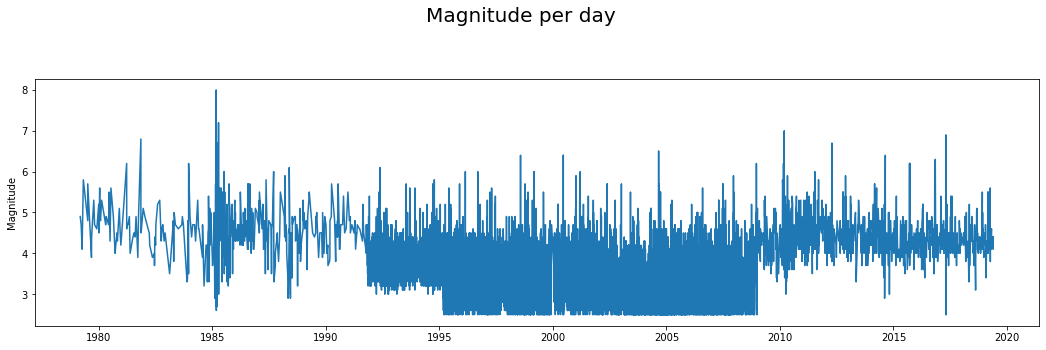

In [12]:
common.plot(sismos['date'], sismos['mag'], 'Magnitude', 'Magnitude per day')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ab32160>,
      dtype=object)

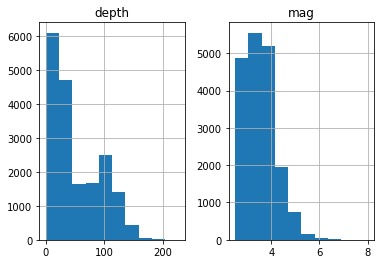

In [13]:
sismos.hist(['depth','mag'])

## 1.2. Time Series Data

In [14]:
read_data.read_data_time_series?

Signature: read_data.read_data_time_series(path)
Docstring:
Return required DataFrames for Time Series Analysis
:return: frequency_year, time_series_magnitude
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [15]:
frequency_year, mag_ym = read_data.read_data_time_series('./data/')

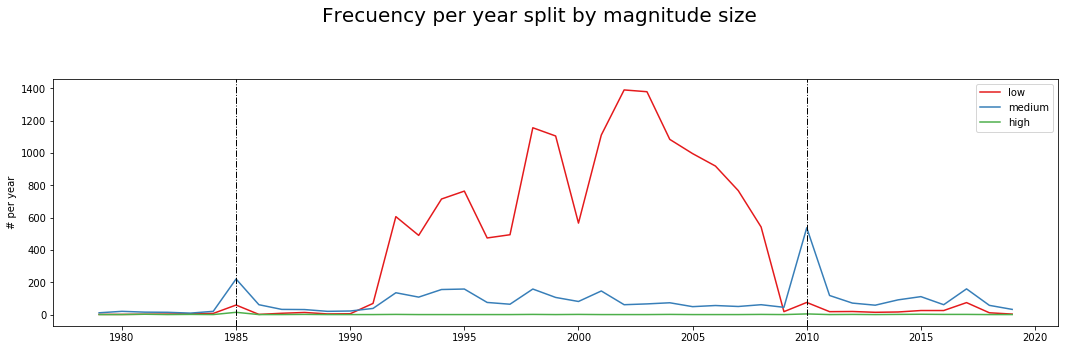

In [16]:
common.plot_time_series_with_big_earthquakes('Frecuency per year split by magnitude size', '# per year',
                                     'year',frequency_year,'magcount','magtype',sismos)

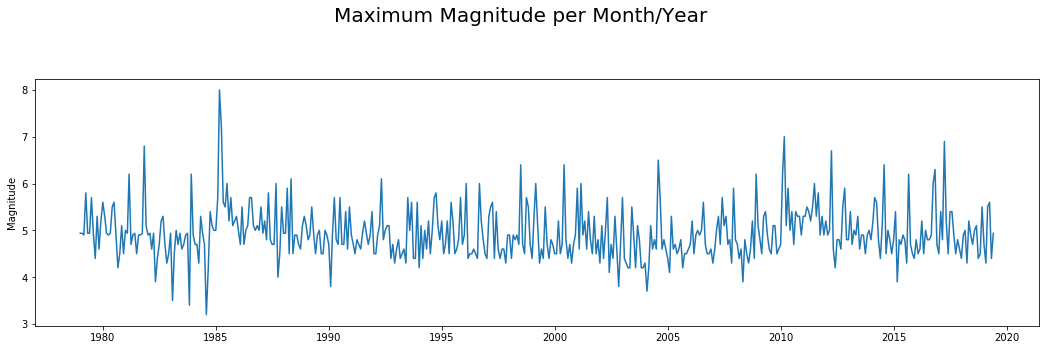

In [17]:
common.plot(mag_ym.index, mag_ym['mag'], 'Magnitude', 'Maximum Magnitude per Month/Year')

## 1.3. Classification Data

In [18]:
read_data.read_data_classification?

Signature: read_data.read_data_classification(path)
Docstring:
 Read Temperature file and return a Dataframe and a Series

:return: features_classification and  label_classification

 features_classification = ['YM', '2', '3', '4', '5', '6', '7', '8', 'Tempt', 'TemptUncert']
                       where YM reference to month/year
                       and '2', '3', '4', '5', '6', '7', '8' contain the number of earthquakes of that magnitude

 label_classification = 1 if (next month has earthquakes > = 6) else is 0,
 so if a know the earthquakes magnitudes and temperatures of the current month, then I can predict next month
 
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/read_data.py
Type:      function


In [19]:
features_classification, label_classification = read_data.read_data_classification('./data/')

In [20]:
features_classification.head(2)

,YM,2,3,4,5,6,7,8,Tempt,TemptUncert
0,1979-01-01,0,0,0,0,0,0,0,12.245,0.183
1,1979-02-01,0,0,0,0,0,0,0,11.158,0.313


In [21]:
label_classification[:3]

0    0
1    0
2    0
dtype: int64

In [22]:
title_figure = 'Frecuency per month/year split by magnitude'
y_label = '# per month/year'
column_x='YM'
data_frame = features_classification
column_y = ''
column_lines = ['6','7','8']
data_frame_bar = sismos
big_earthquake = False

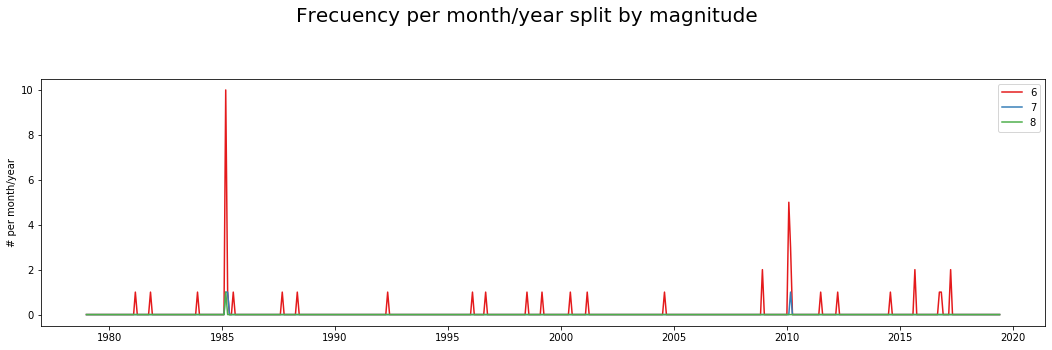

In [23]:
common.plot_regression_with_big_earthquake(title_figure,y_label,column_x,data_frame,column_y,column_lines,data_frame_bar,big_earthquake)

# 2. MODEL

## 2.2. Classification

In [24]:
my_models = supervised_models.Supervised(features_classification.drop('YM', axis=1), label_classification)

2019-06-07 12:05:38,106 [SUP] [INFO]  Initialized Supervised class. Data splited into Train, Test



In [25]:
my_models.evaluate_best_model?

Signature: my_models.evaluate_best_model(models)
Docstring:
Evaluate different models to choose the best one

:param models: should be Dict {ModelName: (Model, Parameter grid to be evaluated)}
:return: best model, evaluated with GridSearchCV
File:      ~/PycharmProjects/TFM_Earthquake/Earthquake_Prediction/models/supervised_models.py
Type:      method


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [27]:
class_models = {'LogisticRegression':     (LogisticRegression(),     {}),
                        'KNeighborsClassifier':   (KNeighborsClassifier(),   {'n_neighbors': np.arange(2, 10)}),
                        'DecisionTreeClassifier': (DecisionTreeClassifier(), {'min_samples_leaf': np.arange(50, 300, 50),
                                                                              'max_depth': np.arange(2, 10)}),
                        'SVC':                    (SVC(kernel="linear"),     {'C': np.arange(1, 3)}),
                        'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': np.arange(1, 3),
                                                                              'max_depth': np.arange(1, 3),
                                                                              'min_samples_leaf': np.arange(1, 3)})}

In [28]:
data_best_model = my_models.evaluate_best_model(class_models)

2019-06-07 12:05:38,174 [SUP] [INFO]  LogisticRegression, Parameters Grid Search: {}
2019-06-07 12:05:38,175 [SUP] [INFO]  Init Cross validation
2019-06-07 12:05:38,197 [SUP] [INFO]  Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), Best Metric accuracy: [0.94897959 0.94845361 0.94845361 0.86597938 0.94845361]

2019-06-07 12:05:38,198 [SUP] [INFO]  KNeighborsClassifier, Parameters Grid Search: {'n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9])}
2019-06-07 12:05:38,900 [SUP] [INFO]  Output: Score 0.9465020576131687 Parameter dict_values([4]) 

2019-06-07 12:05:38,901 [SUP] [INFO]  DecisionTreeClassifier, Parameters Grid Search: {'min_samples_leaf': array([ 50, 100, 150, 200, 250]), 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])}
2019-06-07 12:05:39,564 [SUP] [INFO]  Output

In [29]:
best_model = data_best_model[1][1]

In [30]:
y_hat = best_model.predict(my_models.X_test)
y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

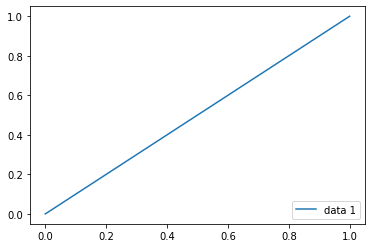

In [31]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(my_models.y_test, y_hat)
auc = metrics.roc_auc_score(my_models.y_test, y_hat)
plt.plot(fpr,tpr,label='data 1') 
         #, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Very bad model!!
Model predicts that never will be a earthquake.... hopefully! 
As I told before, objective was to learn not to predict earthquake.